In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import seaborn as sns
import modules_TFM as mod
import random as rd

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

In [5]:
full_data=pd.read_hdf('C:/Users/pablo/OneDrive - Universidade de Santiago de Compostela/Máster/TFM/ldc1_merged.h5')

### Selección de datos.

Impongo que $0<DT<1150$ para estar lejos de la zona de alphas, y además mantengo el corte de $S1_e>5pes$ 

In [7]:
real_data=full_data[(full_data.DT>0) & (full_data.DT<1150) & (full_data.S1e>5)]

Construyo la ventana de eventos que considero válidos a partir de la función $f$ que se define a continuación y se dibujan los eventos considerados válidos.

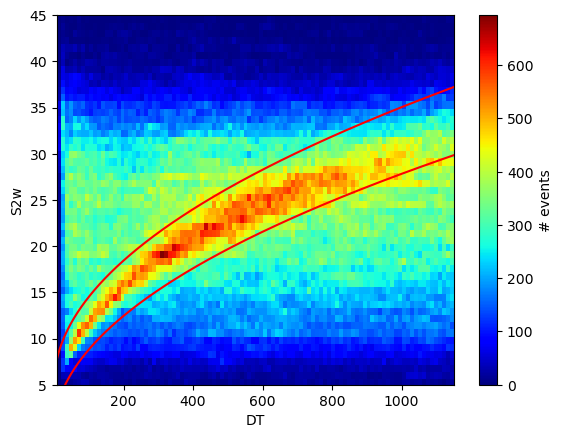

In [11]:
f= lambda x,a,b: a+b*x**0.5
f1 = lambda x: f(x,5,.95)
f2 = lambda x: f(x,0,0.88)

plt.hist2d(real_data.DT,real_data.S2w,bins=100,cmap='jet');
plt.colorbar(label='# events')
plt.xlabel('DT')
plt.ylabel('S2w')
plt.ylim(5,45)

x=np.linspace(0, max(real_data.DT),len(real_data.S2w))
plt.plot(x,f1(x), color='red');
plt.plot(x,f2(x), color='red');  

A continuación filtro los eventos que están dentro de la ventana definida antes, considerando estos válidos y defino una función que me va a permitir calcular el número de S1 por S2

In [13]:
DT_raw=real_data.DT
s2w_raw=real_data.S2w
mask=(s2w_raw<f1(DT_raw))&(s2w_raw>f2(DT_raw))
inverse_mask=~mask

dst_in=real_data[mask]
dst_out=real_data[inverse_mask & (DT_raw>0)]

def recompute_npeaks(df):
    events= df.groupby('event')
    ns1= events.s1_peak.nunique().values
    ns2= events.s2_peak.nunique().values
    n = events.s1_peak.count ().values
    df.loc[:, 'nS1'] = np.repeat(ns1,n) 
    df.loc[:, 'nS2']= np.repeat(ns2,n)
    return df

Me quedo con los eventos que solo tengan un único S1 y los almaceno en el dataset con el que trabajaré $dst$

In [15]:
dst_inr=recompute_npeaks(dst_in)
dst=dst_inr[dst_inr.nS1==1]

### Cálculo de los parámetros de difusión.

Viendo la expresión dada en el paper hecho para NEW, calculo el profile de $Z_{rms}^2$ con $DT$ usando mi función de profiles.

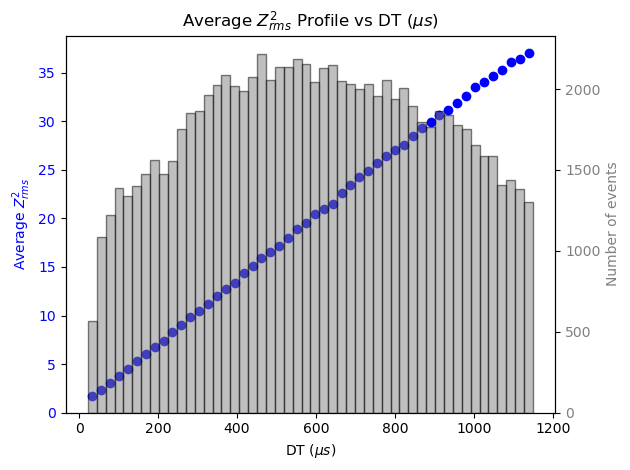

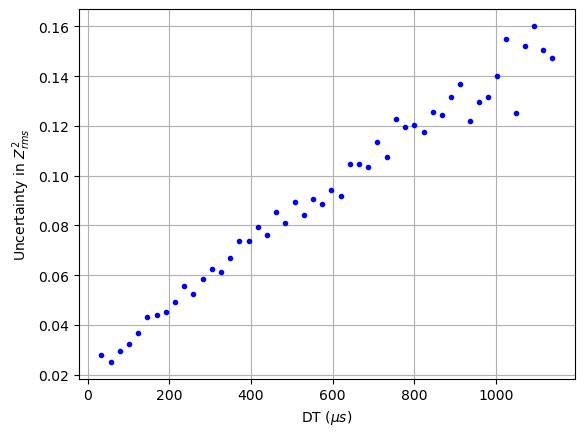

In [19]:
DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms = mod.profiles(dst['DT'], dst['Zrms']**2, threshold=0, x_label=r'DT ($\mu s$)', y_label=r'$Z_{r ms}^2$',plot=True, normalize=True);

Supongo una $v_d=1 mm/\mu s$ y creo un objeto que almacena los datos que me da el profile (está la clase definida en la macro de modules TFM)

In [21]:
drift_velocity=1 # mm/ mu s !!!!!
profile_data_L=mod.Data1d(DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms)

Ajusto a una recta según la fórmula $7.2$ del paper de NEW

In [23]:
def recta(x, a, b):
    return a*x+b

profile_data_L.fit(recta, p0=[0,0]);

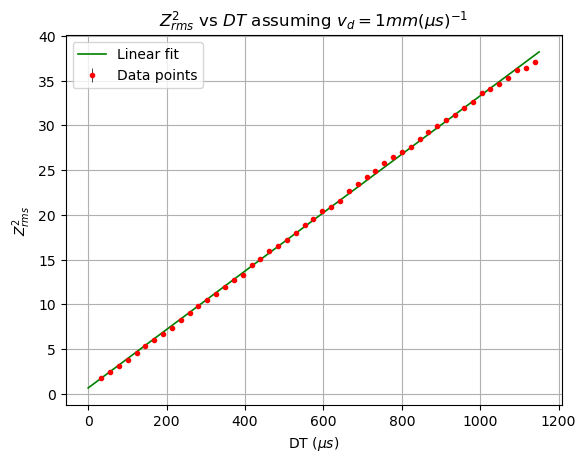

In [25]:
profile_data_L.plot()
plt.plot(np.linspace(0,1150,1000), recta(np.linspace(0,1150,1000), profile_data_L.fit(recta, p0=[0,0])[0][0],
                                        profile_data_L.fit(recta, p0=[0,0])[0][1]), linewidth=1.2, color='green',
                                        label='Linear fit')
plt.xlabel(r'DT ($\mu s)$')
plt.ylabel(r'$Z_{rms}^2$')
plt.title(r'$Z_{rms}^2$ vs $DT$ assuming $v_{d} = 1 mm(\mu s)^{-1}$')
plt.legend()
plt.grid(True)
plt.savefig('Zrms vs DT')

Repito para la difusión transversal.

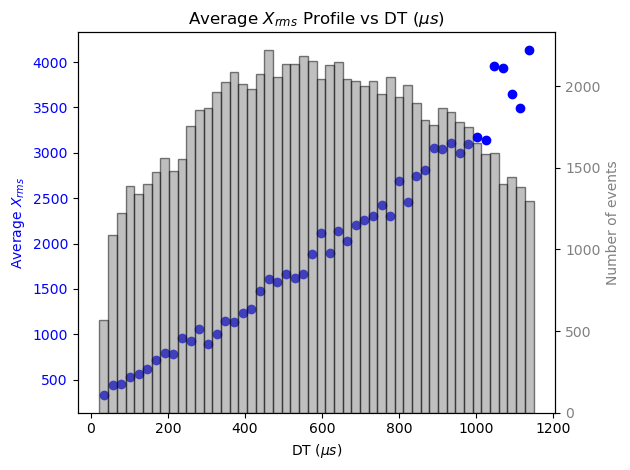

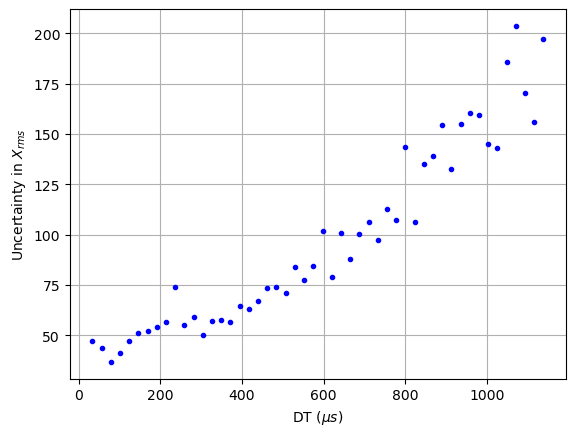

In [28]:
DT_prof, X_rms_mean_sq, X_rms_mean_sq_rms = mod.profiles(dst.DT, dst.Xrms**2, threshold=0, x_label=r'DT ($\mu s$)', y_label=r'$X_{r ms}$',plot=True,normalize=True);

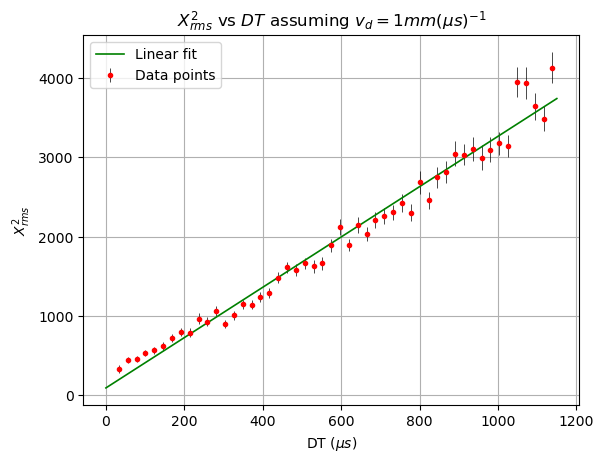

In [30]:
profile_data_T=mod.Data1d(DT_prof, X_rms_mean_sq, X_rms_mean_sq_rms)

profile_data_T.plot()
plt.plot(np.linspace(0,1150,1000), recta(np.linspace(0,1150,1000), profile_data_T.fit(recta, p0=[0,0])[0][0],
                                        profile_data_T.fit(recta, p0=[0,0])[0][1]), linewidth=1.2, color='green',
                                        label='Linear fit')
plt.xlabel(r'DT ($\mu s)$')
plt.ylabel(r'$X_{rms}^2$')
plt.title(r'$X_{rms}^2$ vs $DT$ assuming $v_{d} = 1 mm(\mu s)^{-1}$')
plt.legend()
plt.grid(True)
plt.savefig('X_rms vs DT')

### Trabajando en esta 

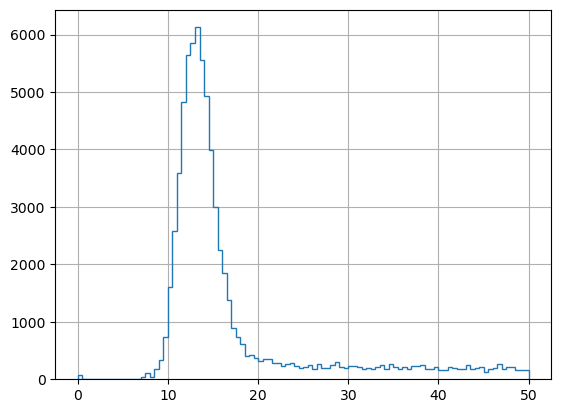

In [36]:
dst.Xrms.hist(bins=100, histtype='step', range=(0,50));